# Dataset:

Para este projeto foram utilizados dados públicos do Sistema de Aeronaves não Tripuladas (SISANT), um orgão da Agência Nacional de Aviação Civil (ANAC), hospedados no portal [Dados Abertos](https://dados.gov.br/dados/conjuntos-dados/aeronaves-drones-cadastrados), contendo as aeronaves não tripuladas cadastradas em cumprimento ao parágrafo E94.301(b) do [RBAC-E No 94](https://www.anac.gov.br/assuntos/legislacao/legislacao-1/rbha-e-rbac/rbac/rbac-e-94).

O objetivo deste projeto é fixar métodos e práticas de data analytics utilizando Python. Considerando que os dados são crus, a experiência torna-se mais didática, uma vez que precisarão de pré-processamento.

Assim sendo, pretende-se responder as seguintes perguntas:
- Quantos drones estão cadastrados no dataset? Qual o status de cada cadastro?
- Quantos diferentes OPERADORes estão cadastrados? Quais suas naturezas?
- Qual uso é feito desses drones?
- Qual empresa é a maior FABRICANTE? E quais seus os MODELOs mais populares?


### Importando módulos:

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from re import match
from wordcloud import WordCloud
%matplotlib inline

pd.options.mode.chained_assignment = None
sns.set_theme(
    style = 'white',
    palette = 'tab10')

### Carregando e visualizando dados:

In [97]:
url = r'https://sistemas.anac.gov.br/dadosabertos/Aeronaves/drones%20cadastrados/SISANT.csv'

df = pd.read_csv(
    url,
    delimiter=';',
    skiprows=1,
    parse_dates=['DATA_VALIDADE'],
    date_parser=lambda x: pd.to_datetime(x, format=r'%d/%m/%Y')
    )

df.dropna(inplace=True)
df.head()

,CODIGO_AERONAVE,DATA_VALIDADE,OPERADOR,CPF_CNPJ,TIPO_USO,FABRICANTE,MODELO,NUMERO_SERIE,PESO_MAXIMO_DECOLAGEM_KG,RAMO_ATIVIDADE
0,PP- 11082012,2024-01-05,Matias Cherem Dala Stella,CPF:***.819.907-**,Básico,DJI,Mavic,08QCE7C0120QNU,0.743,Aerocinematografia
1,PP- 26534803,2024-04-07,WANDERLEI,CPF:***.780.038-**,Básico,DJI,Mavic 2 Pro,163dG6G00170Y0,9.000,Aerofotografia
2,PP- 35041299,2024-01-03,FRANCISCO GABRIEL,CPF:***.589.926-**,Básico,DJI,Mavic,3YTBJAB,0.128,Aeroinspeção
3,PP- 40211550,2023-05-05,Companhia de inteligência urbana e servicos S/A,CNPJ: 40.211.550/0001-74,Básico,DJI,Phantom 4 Pro,11UDH38R710533,1.388,Aerolevantamento - Aerofotogrametria
4,PR-228470326,2024-06-23,IGOR DE OLIVEIRA SAMPAIO,CPF***.918.588-**,Básico,DJI,Spark (MM1A),0asufa800201yz,0.270,Recreativo


### Metadados do dataset:

- **CODIGO_AERONAVE**: Código da Aeronave. Segue regras:
    - Uso Recreativo (AeroMODELO): PR-XXXXXXXXX
    - Uso não recreativo básico (RPA Classe 3 operada em linha de visada visual abaixo de 400 pés): PP-XXXXXXXXX
    - Uso avançado (RPA Classe 2 e demais Classe 3): PS-XXXXXXXXX  
Obs: cada X representa um número 0-9




- **DATA_VALIDADE**: Data de validade, que é igual a data em que o cadastro foi feito ou renovado mais 2 (dois) anos  
- **OPERADOR**: Nome do responsável pela operação do drone  
- **CPF/CNPJ**: Número do CPF ou do CNPJ do responsável pela operação do drone

- **Tipo de Uso**:
    - Básico: aeroMODELOs ou RPA Classe 3 operada exclusivamente na linha de visada visual abaixo de 400 pés AGL
    - Avançado: RPA Classe 2 ou demais RPA classe 3

- **FABRICANTE**: Nome do FABRICANTE da aeronave  
- **MODELO**: Nome do MODELO da aeronave  
- **Número de serie**: Número de série da aeronave  
- **Peso máximo de decolagem**: Peso máximo de decolagem, numérico com 2 (duas casas decimais) em kg
- **Ramo de atividade**: 
    - Recreativo (aeroMODELOs)
    - Experimental (aeronave avançada destinada exclusivamente a operações com propósitos experimentais)
    - Outros ramos de atividade conforme declarado pelo cadastrante

## Informações sobre as colunas:

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109493 entries, 0 to 109707
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CODIGO_AERONAVE           109493 non-null  object        
 1   DATA_VALIDADE             109493 non-null  datetime64[ns]
 2   OPERADOR                  109493 non-null  object        
 3   CPF_CNPJ                  109493 non-null  object        
 4   TIPO_USO                  109493 non-null  object        
 5   FABRICANTE                109493 non-null  object        
 6   MODELO                    109493 non-null  object        
 7   NUMERO_SERIE              109493 non-null  object        
 8   PESO_MAXIMO_DECOLAGEM_KG  109493 non-null  float64       
 9   RAMO_ATIVIDADE            109493 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 9.2+ MB


In [99]:
df.describe(include='all', datetime_is_numeric=True)

,CODIGO_AERONAVE,DATA_VALIDADE,OPERADOR,CPF_CNPJ,TIPO_USO,FABRICANTE,MODELO,NUMERO_SERIE,PESO_MAXIMO_DECOLAGEM_KG,RAMO_ATIVIDADE
count,109493,109493,109493,109493,109493,109493,109493,109493,109493.000000,109493
unique,109466,NaN,82296,76154,2,2882,9038,96915,NaN,2873
top,PR-026111974,NaN,CONFEDERACAO BRASILEIRA DE AEROMODELISMO,CNPJ: 42.508.044/0001-77,Básico,DJI,Mavic,01,NaN,Recreativo
freq,2,NaN,596,615,109186,91646,18158,244,NaN,59509
mean,NaN,2024-01-27 04:28:00.896495872,NaN,NaN,NaN,NaN,NaN,NaN,17.138669,NaN
min,NaN,2022-08-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,2023-07-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.270000,NaN
50%,NaN,2024-02-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.734000,NaN
75%,NaN,2024-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.300000,NaN
max,NaN,2025-02-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4322.220000,NaN


Para responder a primeira pergunta foi necessário indexar o dataframe. A coluna CODIGO_AERONAVE era ideal para isso, já que teoricamente apresenta valores únicos e padronizados.   
Porém, foram observados valores duplicados na coluna que precisaram ser removidos.

In [100]:
#removendo possíveis espaços em branco
df['CODIGO_AERONAVE'] = df['CODIGO_AERONAVE'].str.strip()
df['CODIGO_AERONAVE'] = df['CODIGO_AERONAVE'].str.replace(" ", "")

#checando as duplicatas para entender se as outras colunas também possuem dados repetidos
dupl = df[df.duplicated(subset=['CODIGO_AERONAVE'], keep=False)]
print(dupl.sort_values(by=['CODIGO_AERONAVE']).head(6))

       CODIGO_AERONAVE DATA_VALIDADE OPERADOR                  CPF_CNPJ  \
106756    PP-020010127    2024-08-29      VOA  CNPJ: 28.977.952/0001-89   
95380     PP-020010127    2024-08-29      VOA  CNPJ: 28.977.952/0001-89   
14553     PP-030010110    2024-08-29      VOA  CNPJ: 28.977.952/0001-89   
97452     PP-030010110    2024-08-29      VOA  CNPJ: 28.977.952/0001-89   
91462     PP-030010120    2024-08-29      VOA  CNPJ: 28.977.952/0001-89   
68458     PP-030010120    2024-08-29      VOA  CNPJ: 28.977.952/0001-89   

       TIPO_USO FABRICANTE    MODELO NUMERO_SERIE  PESO_MAXIMO_DECOLAGEM_KG  \
106756   Básico        Voa   Voa-001     2020/127                      15.0   
95380    Básico        Voa   Voa-001     2020/127                      15.0   
14553    Básico        Voa  Voan-300     2020/310                       2.0   
97452    Básico        Voa  Voan-300     2020/310                       2.0   
91462    Básico        Voa  Voan-300     2020/320                       2.0   


Considerando que os registros são repetições idênticas, foram eliminadas então as últimas entradas.   
Em seguida, a coluna também foi verificada quanto a valores que não seguiam os padrões de dígitos apresentados nos metadados do dataset.  
Finalmente, a coluna 'CODIGO_AERONAVE' foi transformada no index do dataframe.

In [101]:
#Limpando as duplicatas
df = df.drop_duplicates(subset=['CODIGO_AERONAVE'], keep='first')

#checando se os padrões de código seguem os descritos nos metadados e removendo os que não seguirem
nrows_before = df.shape[0]

mask = []
for code in df['CODIGO_AERONAVE']:
    mask.append(bool(match('^(PR|PP|PS)-\d{9}$', code)))
df = df[mask]

nrows_after = df.shape[0]
print(f'Registros removidos por padrão inválido: {nrows_before - nrows_after}')
print(f'Quantidade de registros válidos no df: {nrows_after}')

#transformando a coluna no index do dataframe:
df = df.set_index(df['CODIGO_AERONAVE'])
#df = df.drop(('CODIGO_AERONAVE'), axis=1)

Registros removidos por padrão inválido: 15
Quantidade de registros válidos no df: 109451


Com o index do dataframe pronto, seguiu-se com a preparação dos dados. As colunas DATA_VALIDADE, CPF_CNPJ, TIPO_USO, FABRICANTE, PESO_MAXIMO_DECOLAGEM_KG e RAMO_ATIVIDADE foram validadas e, quando necessário, transformadas.

In [102]:
#validando a coluna 'CPF_CNPJ'
df['CPF_CNPJ'].str.strip()
df['CPF_CNPJ'].str.replace(" ", "")
if df['CPF_CNPJ'].value_counts().sum() == nrows_after:
    print('Coluna CPF_CNPJ: OK')
else:
    print('Coluna CPF_CNPJ: Problema')

#validando coluna TIPO_USO e convertendo dtype
df['TIPO_USO'] = df['TIPO_USO'].astype('category')
if df['TIPO_USO'].value_counts().sum() == nrows_after:
    print('Coluna TIPO_USO: OK')
else:
    print('Coluna TIPO_USO: Problema')

Coluna CPF_CNPJ: OK
Coluna TIPO_USO: OK


As colunas 'FABRICANTE' e 'MODELO' precisaram de maior atenção pois, dada a natureza de seu input, apresentam diferentes valores para mesma categoria  
Exemplo: 'DJI', 'dji' e 'Dji' representam a mesma FABRICANTE, DJI.

Iniciou-se pela coluna 'FABRICANTE':

In [103]:
#criando função para, dada uma coluna e um dicionário de sinônimos, os nomes sejam substituídos por valores padronizados 
def fix_names(column, namemap, df=df):
    for fixed_name, bad_names in namemap.items():
        df.loc[df[column].str.contains(bad_names, regex=True), column] = fixed_name


df['FABRICANTE'] = df['FABRICANTE'].str.lower()
df['FABRICANTE'] = df['FABRICANTE'].str.strip()
df['FABRICANTE'] = df['FABRICANTE'].str.replace(" ", "")

#o dicionario foi criado a partir dos valores mais comuns (value_counts()), porém, dada a alta quantidade de valores únicos, FABRICANTEs de
#menor expressão e desconhecidos foram agrupados na categoria 'outros'       
fab_map = {
    'autelrobotics': 'autel',
    'c-fly': 'cfly|c-fly',
    'custom': 'fabrica|aeroMODELO|propria|própria|proprio|próprio|caseiro|montado|artesanal|constru',
    'dji': 'dji|mavic|phanton|phantom',
    'flyingcircus': 'circus',
    'geprc': 'gepr',
    'highgreat': 'highgreat',
    'horus': 'horus',
    'hubsan': 'hubsan|hubsen',
    'nuvemuav': 'nuvem',
    'outros': 'outro',
    'parrot': 'parrot',
    'phoenixmodel': 'phoenix',
    'santiago&cintra': 'santiago|cintra',
    'sensefly': 'sensefly',
    'shantou': 'shantou',
    'sjrc': 'sjrc|srjc',
    'visuo': 'visuo',
    'x-fly': 'xfly|x-fly',
    'xiaomi': 'xiaomi|fimi|xiomi',
    'xmobots': 'xmobots',
    'zll': 'zll|sg906'
    }

#transformando nomes de FABRICANTEs
fix_names('FABRICANTE', fab_map)

df['FABRICANTE'] = df['FABRICANTE'].astype('category')

if df['FABRICANTE'].value_counts().sum() == nrows_after:
    print('Coluna FABRICANTE: OK')
else:
    print('Coluna FABRICANTE: Problema')

Coluna FABRICANTE: OK


Enquanto a próxima coluna, 'MODELO', será transformada posteriormente, pois iremos trabalhar apenas com os MODELOs da maior fornecedora (FABRICANTE) de drones do dataset.

Finalmente, a coluna 'RAMO_ATIVIDADE' também foi validada e transformada. Essa coluna classifica os drones nas categorias Recreativo, Experimental e Outras atividades, sendo essa última categoria especificada livremente pelo usuário.


In [104]:
df['RAMO_ATIVIDADE'] = df['RAMO_ATIVIDADE'].str.lower()
df['RAMO_ATIVIDADE'] = df['RAMO_ATIVIDADE'].str.strip()
df['RAMO_ATIVIDADE'] = df['RAMO_ATIVIDADE'].str.replace(" ", "")

#novamente foi criado um dicionário baseado nos valores mais comuns para padronizá-los e reduzir a quantidade de categorias
act_map = {
    'educação': 'treinamento|educa|ensin|pesquis',
    'engenharia': 'pulveriz|aeroagr|agricultura|levantamento|fotograme|prospec|topografia|minera|capta|avalia|mapea|geoproc|engenharia|energia|solar|ambiental|constru|obras|industria|arquitetura|meioambiente',    
    'foto&cinem': 'fotografia|cinema|inspe|vídeo|video|fotos|jornal|filma|maker|audit|monit|perícia|audiovisu|vistoria|imagens|turismo|youtube|imobili|imóveis',
    'logística': 'transport|carga|delivery',
    'publicidade': 'publicid|letreir|show|marketing|demonstr|eventos|comercial',
    'segurança': 'seguran|fiscaliza|reporta|vigi|policia|bombeiro|defesa|combate|emergencia|infraestrutura'
    }

#corrigindo nomes a partir do dicionário, reclassificando atividades mais específicas em 'outros' e convertendo o dtype da coluna
fix_names('RAMO_ATIVIDADE', act_map, df)
df.loc[
    ~df['RAMO_ATIVIDADE'].isin(
        df['RAMO_ATIVIDADE'].value_counts().head(8).index
        ), 'RAMO_ATIVIDADE'
    ] = 'outros'
df['RAMO_ATIVIDADE'] = df['RAMO_ATIVIDADE'].astype('category')

if df['RAMO_ATIVIDADE'].value_counts().sum() == nrows_after:
    print('Coluna RAMO_ATIVIDADE: OK')
else:
    print('Coluna RAMO_ATIVIDADE: Problema')

Coluna RAMO_ATIVIDADE: OK


In [105]:
#dropando colunas que não serão utilizadas na análise
df = df.drop(('NUMERO_SERIE'), axis=1)
df = df.drop(('PESO_MAXIMO_DECOLAGEM_KG'), axis=1)

#conferindo as informações do dataset pré-processado
df.describe(include='all', datetime_is_numeric=True)

,CODIGO_AERONAVE,DATA_VALIDADE,OPERADOR,CPF_CNPJ,TIPO_USO,FABRICANTE,MODELO,RAMO_ATIVIDADE
count,109451,109451,109451,109451,109451,109451,109451,109451
unique,109451,NaN,82283,76144,2,1854,9037,9
top,PR-228470326,NaN,CONFEDERACAO BRASILEIRA DE AEROMODELISMO,CNPJ: 42.508.044/0001-77,Básico,dji,Mavic,recreativo
freq,1,NaN,596,615,109145,92199,18152,59488
mean,NaN,2024-01-27 03:15:56.449918464,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2022-08-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2023-07-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2024-02-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2024-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2025-02-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


## Análise exploratória do dataframe:  

A coluna 'DATA_VALIDADE', como o próprio nome sugere, apresenta as datas em que os cadastros devem ser renovados. Conforme a legislação, sabe-se que o prazo de expiração é de dois anos contados a partir da data de cadastro, e que após seis meses de expiração o cadastro não é mais renovável (torna-se inativo), podemos obter dois tipos de informação a partir dessa coluna:  
- A data de adesão da aeronave ao sistema;
- Quantos cadastros encontram-se fora do prazo de validade, carecem de renovação ou recadastramento.   

Foram verificados 109451 cadastros, sendo 0 inativos (0.0%), 12900 a serem renovados (11.8%) e 96551 regulares (88.2%).


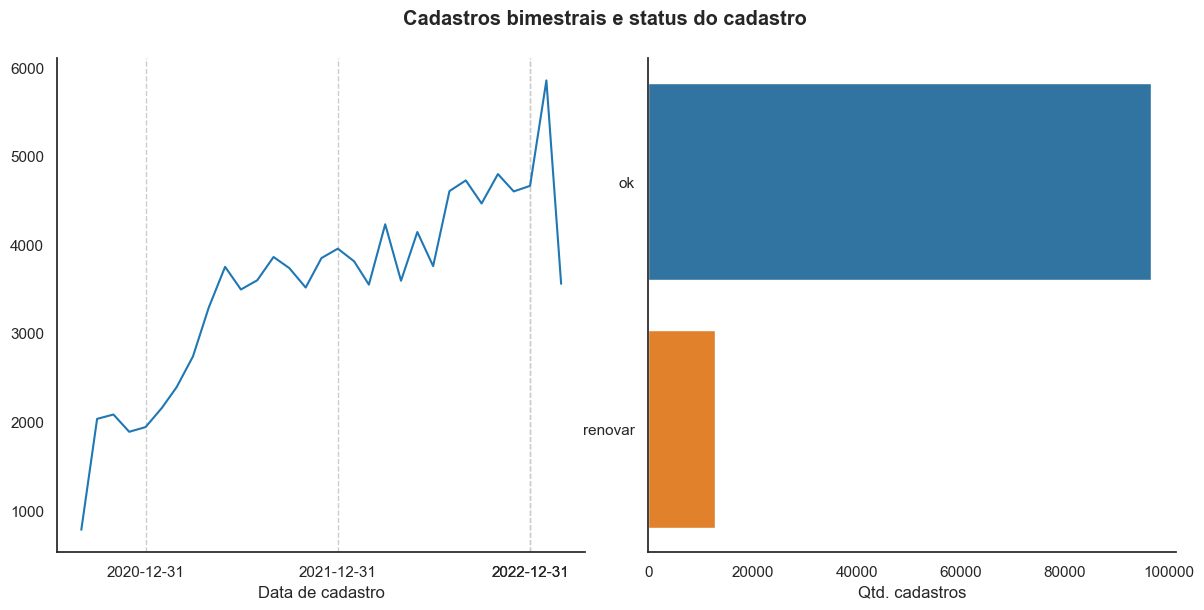

In [106]:
#criando coluna 'DATA_CADASTRO'
df['DATA_CADASTRO'] = df['DATA_VALIDADE'] - pd.DateOffset(years=2)

#criando função que classifica datas conforme situação do cadastro
def status_cadastro(date):
    today = pd.Timestamp.today()
    if date < today:
        return 'renovar'
    elif date + pd.DateOffset(months=6) < today:
        return 'inativo'
    return 'ok'

#criando coluna 'STATUS', contendo dados categorizados sobre cada aeronave (cadastro ok, renovar ou inativo)
df['STATUS'] = df['DATA_VALIDADE'].apply(status_cadastro)
df['STATUS'] = df['STATUS'].astype('category')

#calculando valores e criando gráfico
num_inat = df[df['STATUS']=='inativo'].shape[0]
num_renov = df[df['STATUS']=='renovar'].shape[0]
num_ok = df[df['STATUS']=='ok'].shape[0]

fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Cadastros bimestrais e status do cadastro', weight='bold')
fig.tight_layout()

#agregando dados em bimestres
agg_data = df.resample('M', on='DATA_CADASTRO').count()
agg_data.reset_index(inplace=True)

#criando gráfico 1
sns.lineplot(
    x='DATA_CADASTRO', y='OPERADOR',
    data=agg_data, 
    ax=axs[0],
    )

axs[0].grid(axis='x', linestyle='--')
axs[0].yaxis.grid(False)

#xmin, xmax = cad_count.get_xlim()
#xticks = np.linspace(xmin, xmax, 5)
axs[0].set(
    xticks=['2020-12-31', '2021-12-31', '2022-12-31', '2022-12-31'], 
    ylabel=None, 
    xlabel='Data de cadastro',
    )

#criando gráfico 2
sns.countplot(
    df, 
    y='STATUS',
    order=df['STATUS'].value_counts().iloc[:3].index, 
    ax=axs[1]
    )
axs[1].set(
    xlabel='Qtd. cadastros',
    ylabel=None,
    )

sns.despine(ax=axs[0])
sns.despine(ax=axs[1])

print(f'Foram verificados {df.shape[0]} cadastros, sendo {num_inat} inativos ({round(num_inat / df.shape[0] * 100, ndigits=1)}%), {num_renov} a serem renovados ({round(num_renov / df.shape[0] * 100, ndigits=1)}%) e {num_ok} regulares ({round(num_ok / df.shape[0] * 100, ndigits=1)}%).')

Observou-se que a taxa de adesão de aeronaves ao sistema vem crescendo a cada mês, apesar da queda recente na quantidade de cadastros.

Antes de analisar a coluna OPERADOR é preciso confrontar os dados com a coluna 'CPF_CNPJ', uma vez que os valores da última são únicos. A coluna 'OPERADOR' contém input de texto humano e, em múltiplos registros, foram encontrados diferentes nomes para o mesmo CPF/CNPJ. 
 
Foi ainda criada uma coluna chamada 'NATUREZA_OP' contendo a classificação entre pessoa física (PF) ou jurídica (PJ). É importante mencionar que os valores relacionados ao CPF fornecidos pelo dataset são parcialmente censurados, visando a preservação de dados pessoais.

In [107]:
#agrupando dados pela coluna de valores únicos CPF_CNPJ, sendo que os respectivos valores para a coluna OPERADOR foram enviados para uma lista
op_group = df.groupby('CPF_CNPJ')['OPERADOR'].apply(list).to_dict()

#criando mapa no formato de dicionário onde CPF_CNPJ será a chave e o primeiro valor da lista de operadores será o nome padrão 
op_dict = {k: v[0] for k, v in op_group.items()}

#substituindo valores antigos da coluna OPERADOR pelos nomes corrigidos
unique_ops1 = len(df['OPERADOR'].unique())
df['OPERADOR'] = df['CPF_CNPJ'].map(op_dict)
unique_ops2 = len(df['OPERADOR'].unique())

print(f'A coluna OPERADOR teve {unique_ops1 - unique_ops2} nomes corrigidos.')

#criando coluna NATUREZA_OP contendo classificação dos operadores entre pessoa física ou jurídica
df['NATUREZA_OP'] = df['CPF_CNPJ'].apply(
    lambda x: 'PF' if x.startswith('CPF') else 'PJ'
    ).astype('category')
    

A coluna OPERADOR teve 11083 nomes corrigidos.


O tipo de uso mais frequente é o basico, registrado em 99.7% dos registros.


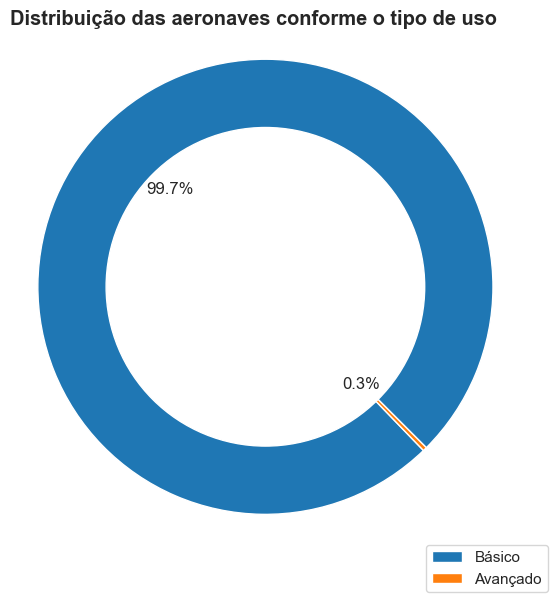

In [108]:
fig, ax = plt.subplots(figsize=(6,6))
fig.tight_layout(pad=2)
fig.suptitle(
    'Distribuição das aeronaves conforme o tipo de uso', 
    weight='bold')

ax.pie(
    df['TIPO_USO'].value_counts(),  
    autopct='%1.1f%%', 
    startangle=315
    )

# draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

fig.legend(
    labels = df['TIPO_USO'].value_counts().index.tolist(), 
    loc = 'lower right'
    )

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')    
sns.despine(ax=ax)

percentage = df['TIPO_USO'].value_counts() / df['TIPO_USO'].value_counts().sum()    
print(f'O tipo de uso mais frequente é o basico, registrado em {round(percentage[0] * 100, 1)}% dos registros.')

Para avançar no entendimento do uso das aeronaves, avaliou-se então a coluna RAMO_ATIVIDADE. Primeiramente, observou-se que a grande maioria dos drones registrados são destinados a atividades recreativas, sendo as atividades de 'fotografia e cinema' e 'engenharia' vindo logo após.

Adicionalmente esses números ainda foram comparados com a coluna NATUREZA_OP, onde verificou-se que as pessoas físicas são maioria em quase todas as atividades, com exceção da engenharia e da segurança.

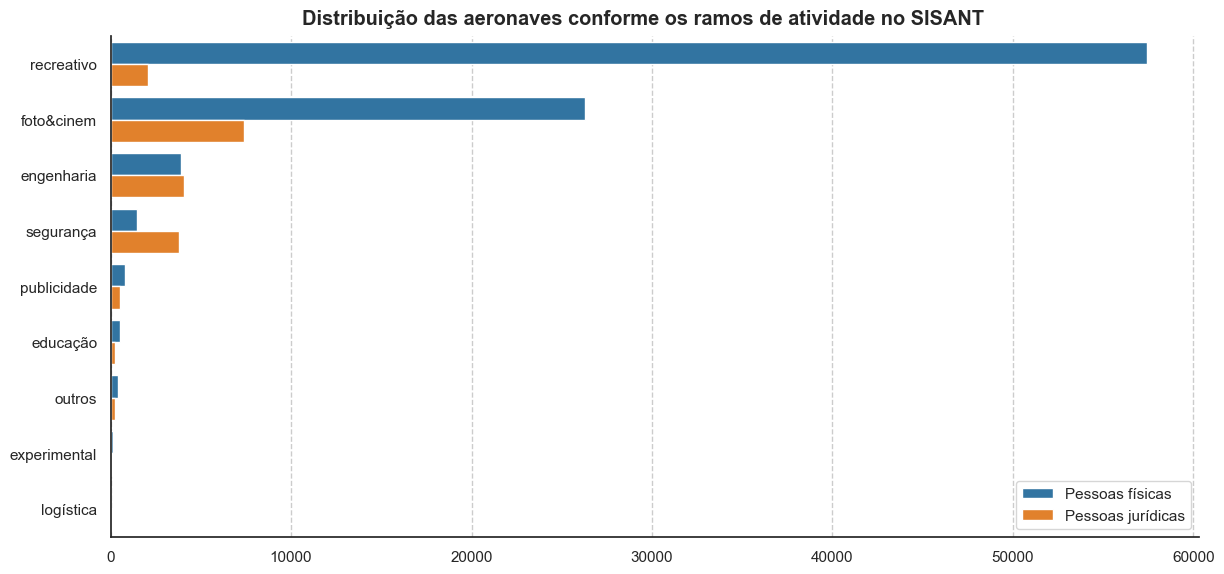

In [109]:
fig, ax = plt.subplots(figsize = (12,6))
fig.tight_layout(pad=2)
fig.suptitle('Distribuição das aeronaves conforme os ramos de atividade no SISANT', weight = 'bold')

ax = sns.countplot(
    df, 
    y = 'RAMO_ATIVIDADE', 
    hue = 'NATUREZA_OP',
    order = df['RAMO_ATIVIDADE'].value_counts().iloc[:10].index
    )

ax.grid(axis = 'x', linestyle = '--')
ax.yaxis.grid(False)
ax.set(xlabel = None, ylabel = None)
ax.legend(
    loc = 'lower right',
    labels = ['Pessoas físicas', 'Pessoas jurídicas']
    )

sns.despine(ax=ax)

Depois analisou-se a questão dos FABRICANTEs e MODELOs de drone. Quanto aos FABRICANTEs, foi observada a dominância da FABRICANTE DJI,

A maior fornecedora é DJI, constando em 84.2% dos registros
dji         92199
xiaomi       4331
sjrc         1069
custom        950
hubsan        941
parrot        821
zll           426
shantou       378
c-fly         289
sensefly      283
Name: FABRICANTE, dtype: int64


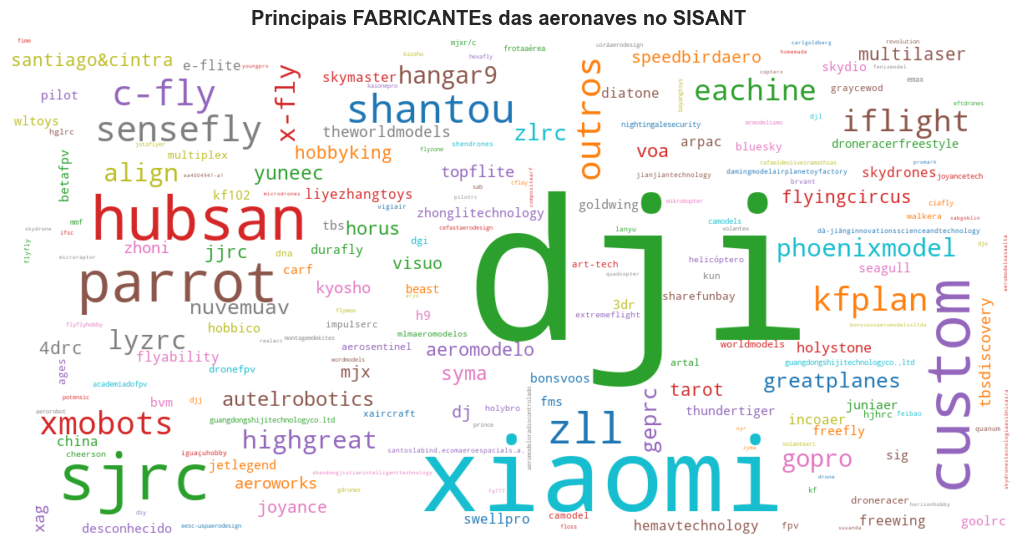

In [110]:
#criando nuvem de palavras para representar a distribuição das FABRICANTEs
fig, ax = plt.subplots(figsize=(12,6))

fig.tight_layout(pad=2)
fig.suptitle('Principais FABRICANTEs das aeronaves no SISANT', weight='bold')

wordcloud = WordCloud(
    width=1200, height=600,
    mode='RGBA', 
    background_color='white',
    #min_font_size=15,
    colormap='tab10'
    ).fit_words(
        df['FABRICANTE'].value_counts().to_dict()
        )

ax.axis("off")
ax.imshow(wordcloud, interpolation='bilinear') 


counts = df['FABRICANTE'].value_counts()
percentages = counts / counts.sum()

print(f'A maior fornecedora é {percentages.index[0].upper()}, constando em {round(percentages[0] * 100, 1)}% dos registros')

print(df['FABRICANTE'].value_counts().head(10))

Foram então verificados quais os principais MODELOs de aeronaves DJI registrados no dataset.

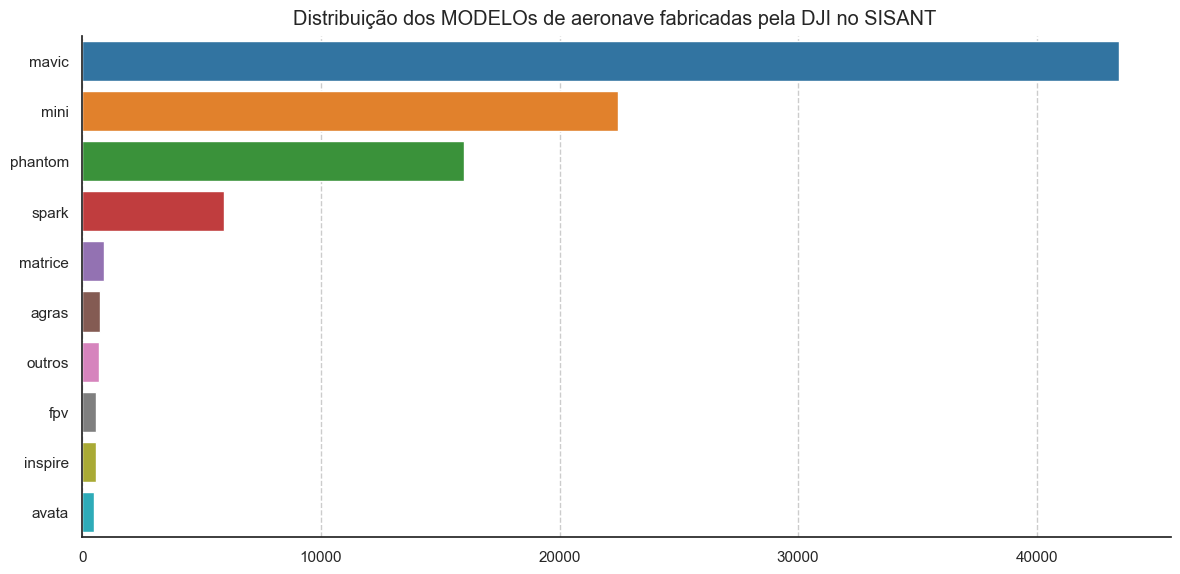

In [111]:
#criando subset contendo os drones fabricados pela dji
dji_df = df.loc[df['FABRICANTE']=='dji']

#transformando os nomes
dji_df['MODELO'] = dji_df['MODELO'].str.lower()
dji_df['MODELO'] = dji_df['MODELO'].str.strip()
dji_df['MODELO'] = dji_df['MODELO'].str.replace(" ", "")

dji_model_map = {
    'mavic': 'mav|air|ma2ue3w|m1p|da2sue1|1ss5|u11x|rc231|m2e|l1p|enterprisedual',
    'phantom': 'phan|wm331a|p4p|w322b|p4mult|w323|wm332a|hanto',
    'mini': 'min|mt2pd|mt2ss5|djimi|mt3m3vd',
    'spark': 'spa|mm1a',
    'matrice': 'matrice|m300',
    'avata': 'avata|qf2w4k',
    'inspire': 'inspire',
    'tello': 'tello|tlw004',
    'agras': 'agras|mg-1p|mg1p|t16|t10|t40|3wwdz',
    'fpv': 'fpv',
    'outros': 'dji'
    }

#transformando nomes de FABRICANTEs
fix_names('MODELO', dji_model_map, dji_df)
dji_df.loc[~dji_df['MODELO'].isin(dji_df['MODELO'].value_counts().head(14).index), 'MODELO'] = 'outros'
dji_df['MODELO'] = dji_df['MODELO'].astype('category')


fig, ax = plt.subplots(figsize=(12,6))
fig.tight_layout(pad=2)
fig.suptitle('Distribuição dos MODELOs de aeronave fabricadas pela DJI no SISANT')

sns.countplot(
    y = dji_df['MODELO'],
    order = dji_df['MODELO'].value_counts().iloc[:10].index,
    ax=ax
    )

ax.grid(
    axis='x', 
    linestyle='--'
    )
#ax.yaxis.grid(False)

ax.set(
    xlabel=None,
    ylabel=None,
)

sns.despine(ax=ax)


Quais as marcas preferidas dos PF e dos PJ?

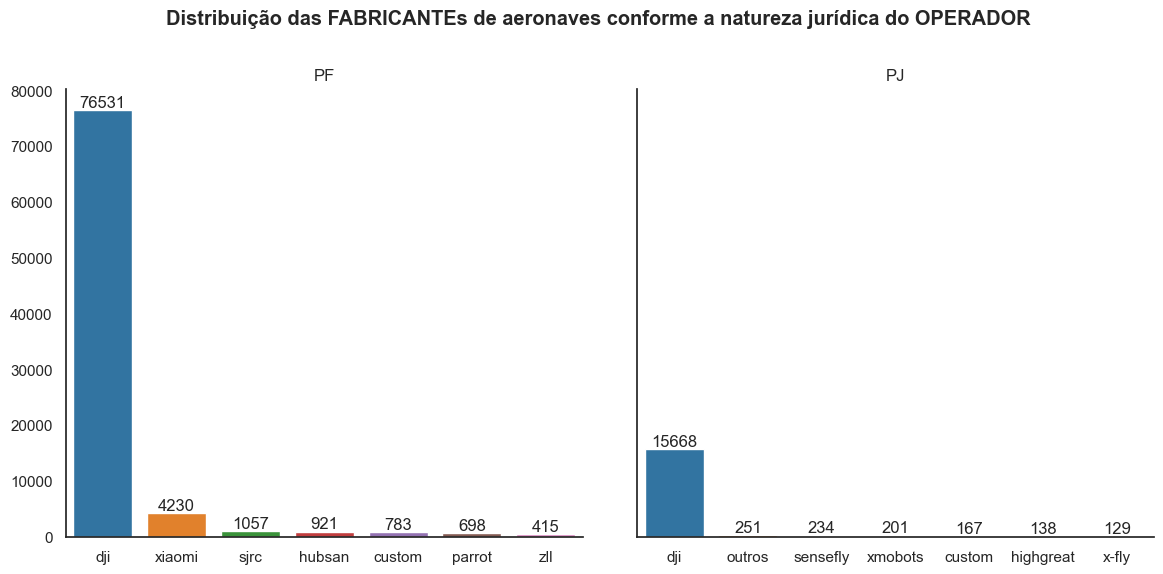

In [112]:
pf_df = df.loc[df['NATUREZA_OP']=='PF', 'FABRICANTE']
pj_df = df.loc[df['NATUREZA_OP']=='PJ', 'FABRICANTE']

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)
fig.suptitle('Distribuição das FABRICANTEs de aeronaves conforme a natureza jurídica do OPERADOR', weight='bold')
fig.tight_layout(pad=2)

sns.countplot(
    x=pf_df, 
    order=pf_df.value_counts().iloc[:7].index, 
    ax=axs[0]
    )

for bar in axs[0].patches:
    height = bar.get_height()
    axs[0].annotate(
        text=f"{int(height)}", 
        xy=(bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom'
        )
   
axs[0].set(
    xlabel=None, 
    ylabel=None,
    title='PF'
    )

sns.despine(ax=axs[0])
    
sns.countplot(
    x=pj_df, 
    order=pj_df.value_counts().iloc[:7].index, 
    ax=axs[1]
    )

for bar in axs[1].patches:
    height = bar.get_height()
    axs[1].annotate(
        text=f"{int(height)}", 
        xy=(bar.get_x() + bar.get_width() / 2, height),
        ha='center', 
        va='bottom'
        )

axs[1].set(
    xlabel=None, 
    ylabel=None,
    title='PJ'
    )

sns.despine(ax=axs[1])


